<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Исследование-задачи" data-toc-modified-id="Исследование-задачи-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Исследование задачи</a></span></li><li><span><a href="#Борьба-с-дисбалансом" data-toc-modified-id="Борьба-с-дисбалансом-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Борьба с дисбалансом</a></span></li><li><span><a href="#Тестирование-модели" data-toc-modified-id="Тестирование-модели-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование модели</a></span><ul class="toc-item"><li><span><a href="#ОБЩИЕ-ВЫВОДЫ" data-toc-modified-id="ОБЩИЕ-ВЫВОДЫ-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>ОБЩИЕ ВЫВОДЫ</a></span></li></ul></li><li><span><a href="#Чек-лист-готовности-проекта" data-toc-modified-id="Чек-лист-готовности-проекта-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист готовности проекта</a></span></li></ul></div>

# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

## Подготовка данных

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, precision_score, recall_score, roc_curve, roc_auc_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.utils import shuffle
pd.options.mode.chained_assignment = None


In [49]:
data = pd.read_csv('https://code.s3.yandex.net/datasets/Churn.csv')
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


Данные выглядят красиво, кроме столбца Tenure с пропусками, а некоторые столбцы кажутся бесполезными (RowNumber, CustomerId).

Типы данных в столбцах соответствуют природе этих данных, преобразования не требуются.

In [50]:
data.duplicated().sum()

0

In [51]:
data['Tenure'].describe() #до заполнения медианой

count    9091.000000
mean        4.997690
std         2.894723
min         0.000000
25%         2.000000
50%         5.000000
75%         7.000000
max        10.000000
Name: Tenure, dtype: float64

In [52]:
# приступим к предобработке данных
data.duplicated().sum() #дубликатов нет, отлично
data['CustomerId'].duplicated().sum()
data['Tenure'].value_counts()

# тяжело определить, какие факторы влияют на продолжительность обслуживания того или иного клиента в нашем банке.
# даже в первых пяти строках есть уходы как среди относительно новых клиентов (2 года), так и среди старых (8 лет).
# поэтому заменим пропущенные значения медианой

data['Tenure'] = data['Tenure'].fillna(data['Tenure'].median())

df = data.drop(['RowNumber', 'CustomerId', 'Surname'], axis='columns')

df.info()
df['Tenure'].describe()

#пропусков нет, типы данных в норме, предобработка окончена

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      10000 non-null  int64  
 1   Geography        10000 non-null  object 
 2   Gender           10000 non-null  object 
 3   Age              10000 non-null  int64  
 4   Tenure           10000 non-null  float64
 5   Balance          10000 non-null  float64
 6   NumOfProducts    10000 non-null  int64  
 7   HasCrCard        10000 non-null  int64  
 8   IsActiveMember   10000 non-null  int64  
 9   EstimatedSalary  10000 non-null  float64
 10  Exited           10000 non-null  int64  
dtypes: float64(3), int64(6), object(2)
memory usage: 859.5+ KB


count    10000.00000
mean         4.99790
std          2.76001
min          0.00000
25%          3.00000
50%          5.00000
75%          7.00000
max         10.00000
Name: Tenure, dtype: float64

## Исследование задачи

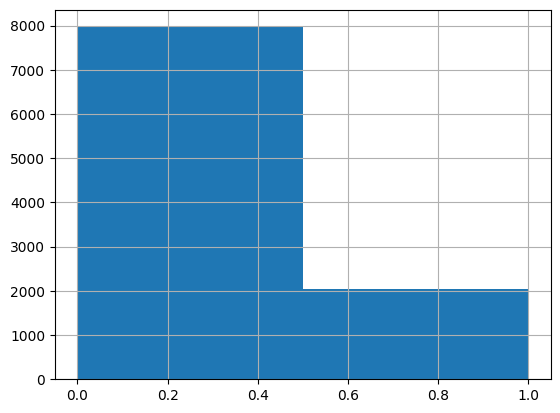

In [53]:
df['Exited'].value_counts()

df['Exited'].hist(bins=2)
plt.show()
# видим сильный дисбаланс ключевого признака

Разобьем данные на выборки и начнем готовить признаки: закодируем категориальные признаки с помощью get_dummies. (Да, я знаю, что OHE лучше, но для этих данных критической разницы в выборе между ними нет.)

In [54]:
df = pd.get_dummies(df, drop_first=True)
df.info()
df.head(10)

target = df['Exited']
features = df.drop('Exited', axis=1)

features_train, features_test, target_train, target_test = train_test_split(
    features, target, train_size=0.6, random_state=12345)

features_test, features_valid, target_test, target_valid = train_test_split(features_test, target_test, train_size=0.5, random_state=12345)

print(features_train.shape)
print(features_test.shape)
print(features_valid.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CreditScore        10000 non-null  int64  
 1   Age                10000 non-null  int64  
 2   Tenure             10000 non-null  float64
 3   Balance            10000 non-null  float64
 4   NumOfProducts      10000 non-null  int64  
 5   HasCrCard          10000 non-null  int64  
 6   IsActiveMember     10000 non-null  int64  
 7   EstimatedSalary    10000 non-null  float64
 8   Exited             10000 non-null  int64  
 9   Geography_Germany  10000 non-null  uint8  
 10  Geography_Spain    10000 non-null  uint8  
 11  Gender_Male        10000 non-null  uint8  
dtypes: float64(3), int64(6), uint8(3)
memory usage: 732.5 KB
(6000, 11)
(2000, 11)
(2000, 11)


Проведём масштабирование данных с помощью StandardScaler.

In [55]:
numeric = ['CreditScore', 'Balance', 'EstimatedSalary']
scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])


features_train.head() #проверяем, что масштабирование прошло как надо

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
7479,-0.886751,35,8.0,1.232271,1,1,0,-0.187705,0,1,1
3411,0.608663,37,8.0,0.600563,1,0,0,-0.333945,0,0,0
6027,2.052152,44,3.0,1.027098,2,0,1,1.503095,1,0,1
1247,-1.457915,24,6.0,-1.233163,2,1,0,-1.071061,0,0,1
3716,0.130961,27,2.0,1.140475,1,0,0,1.524268,1,0,0


Перейдём к обучению моделей.

In [56]:
lr_model = LogisticRegression(random_state=12345, solver='liblinear')
lr_model.fit(features_train, target_train)
lr_predicted_valid = lr_model.predict(features_valid)

lr_F1 = f1_score(target_valid, lr_predicted_valid)
print("lr_F1:", lr_F1)

lr_probabilities_valid = lr_model.predict_proba(features_valid)
lr_probabilities_one_valid = lr_probabilities_valid[:, 1]

lr_auc_roc = roc_auc_score(target_valid, lr_probabilities_one_valid)
print("lr_AUC-ROC:", lr_auc_roc)

lr_F1: 0.27225130890052357
lr_AUC-ROC: 0.7383831706070267


In [57]:
rfc_model = RandomForestClassifier(random_state=12345, n_estimators=100)
rfc_model.fit(features_train, target_train)
rfc_predicted_valid = rfc_model.predict(features_valid)
rfc_predicted_valid

rfc_F1 = f1_score(target_valid, rfc_predicted_valid)
print("RFC F1:", rfc_F1)

rfc_probabilities_valid = rfc_model.predict_proba(features_valid)
rfc_probabilities_one_valid = rfc_probabilities_valid[:, 1]

rfc_auc_roc = roc_auc_score(target_valid, rfc_probabilities_one_valid)
print("RFC AUC-ROC:", rfc_auc_roc)


RFC F1: 0.5465465465465466
RFC AUC-ROC: 0.8502048507580152


Кратко описываю выводы: у модели линейной регрессии на несбалансированных данных результат метрики F1 далек от целевого в 0.59. Модель случайного леса по F1 тоже не дотягивает, но по обеим метрикам результаты лучше.

## Борьба с дисбалансом

Теперь попробуем разные способы борьбы с дисбалансом таргета. Начнём с балансирования весов классов (применимо только в логистической регрессии).

In [58]:
# самое простое - сбалансировать вес классов
model = LogisticRegression(random_state=12345, solver='liblinear', class_weight='balanced')
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)

lr_cw_F1 = f1_score(target_valid, predicted_valid)
print("F1_lr_cw:", lr_cw_F1)

probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
lr_cw_auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print("lr cw AUC-ROC:", lr_cw_auc_roc)

F1_lr_cw: 0.4779220779220779
lr cw AUC-ROC: 0.7415132722004105


Уже получше (F1 выросла почти вдвое), но все еще есть к чему стремиться. AUC-ROC выросла несущественно.

Теперь попробуем upsampling. Прежде чем обучать модели, проверим, новое соотношение классов.

In [59]:
# теперь попробуем upsampling
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    repeat = 4
    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    features_upsampled = shuffle(features_upsampled, random_state=12345)
    target_upsampled = shuffle(target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

features_upsampled, target_upsampled = upsample(features_train, target_train, 4)
print(target_upsampled.value_counts())

0    4804
1    4784
Name: Exited, dtype: int64


In [60]:
model = LogisticRegression(random_state=12345, solver='liblinear')
model.fit(features_upsampled, target_upsampled)
predicted_valid = model.predict(features_valid)

up_lr_F1 = f1_score(target_valid, predicted_valid)
print("up_lr_F1:", up_lr_F1)

probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
up_lr_auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print("AUC-ROC:", up_lr_auc_roc)

up_lr_F1: 0.47660311958405543
AUC-ROC: 0.7415762340140704


In [61]:
model = RandomForestClassifier(random_state=12345, n_estimators=189)
model.fit(features_upsampled, target_upsampled)
predicted_valid = model.predict(features_valid)

up_rf_F1 = f1_score(target_valid, predicted_valid)
print("up_rf_F1:", up_rf_F1)

probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
up_rf_auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print("AUC-ROC:",up_rf_auc_roc)

up_rf_F1: 0.599476439790576
AUC-ROC: 0.8511170475106847


Апсемплинг не сильно помог логистической регрессии. А вот случайный лес благодаря апсемплингу достиг искомого порога в 0,59, хотя AUC-ROC у этой модели даже немного снизилась.

In [62]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled

features_downsampled, target_downsampled = downsample(features_train, target_train, 0.25)
print(target_downsampled.value_counts())

0    1201
1    1196
Name: Exited, dtype: int64


In [63]:
model = LogisticRegression(random_state=12345, solver='liblinear')
model.fit(features_downsampled, target_downsampled)
predicted_valid = model.predict(features_valid)

down_lr_F1 = f1_score(target_valid, predicted_valid)
print("down_lr_F1:", down_lr_F1)

probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
down_lr_auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print("AUC-ROC:", down_lr_auc_roc)

down_lr_F1: 0.4816396242527754
AUC-ROC: 0.7408371822489659


При даунсемплинге удалось добиться F1 лишь в 0,48. Всё ещё маловато. AUC-ROC держится на уровне 0,74.

In [64]:
model = RandomForestClassifier(random_state=12345, n_estimators=400)
model.fit(features_downsampled, target_downsampled)
predicted_valid = model.predict(features_valid)

down_rf_F1 = f1_score(target_valid, predicted_valid)
print("down_rf_F1:", down_rf_F1)

probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
down_rf_auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print("down_rf_AUC-ROC:", down_rf_auc_roc)

down_rf_F1: 0.5826330532212884
down_rf_AUC-ROC: 0.8472051700643559


По случайному лесу при уменьшении выборки F1 и AUC-ROC чуть ниже, чем при апсемплинге. 

In [65]:
cols = ['model', 'F1_score', 'best_auc_roc_score']
model_data = [['base LR', lr_F1, lr_auc_roc],
             ['base RF', rfc_F1, rfc_auc_roc],
             ['class-weighted LR', lr_cw_F1, lr_cw_auc_roc],
             ['upsampled LR', up_lr_F1, up_lr_auc_roc],
             ['downsampled LR', down_lr_F1, down_lr_auc_roc],
             ['upsampled RF', up_rf_F1, up_rf_auc_roc],
             ['downsampled RF', down_rf_F1, down_rf_auc_roc]]
            
model_comparison = pd.DataFrame(data= model_data, columns = cols)
model_comparison

,model,F1_score,best_auc_roc_score
0,base LR,0.272251,0.738383
1,base RF,0.546547,0.850205
2,class-weighted LR,0.477922,0.741513
3,upsampled LR,0.476603,0.741576
4,downsampled LR,0.481640,0.740837
5,upsampled RF,0.599476,0.851117
6,downsampled RF,0.582633,0.847205


Таким образом, при ап- и даунсемплинге случайный лес показывает необходимый нам результат выше 0.59. Но с апсемплингом лучше. Проверим теперь эту модель на тестовой выборке.

## Тестирование модели

In [66]:
model = RandomForestClassifier(random_state=12345, n_estimators=189)
model.fit(features_upsampled, target_upsampled)
predicted_test = model.predict(features_test)

print("F1:", f1_score(target_test, predicted_test))

probabilities_test = model.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
auc_roc = roc_auc_score(target_test, probabilities_one_test)
print("AUC-ROC:", auc_roc)

F1: 0.6055776892430279
AUC-ROC: 0.8400040225261463


Необходимые значения метрик достигнуты.

### ОБЩИЕ ВЫВОДЫ
Мы поработали с данными об уходе клиентов «Бета-Банка», чтобы построить модель, которая помогла бы сохранять текущих клиентов, так как это для компании обходилось бы дешевле, чем привлекать новых. Для этого изучили данные по 10 000 прошлых клиентов, из которых порядка 20% от услуг банка ранее отказались. Провели предобработку данных, после чего приступили к исследованию задачи. Проанализировали модели без учёта дисбаланса, результаты нас не устроили, поэтому стали строить модели с учётом дисбаланса. 
Оптимальной моделью стал случайный лес с апсемплингом, что подтверждается результатами тестирования на тестовой выборке (F1 = 0,61) и метрики AUC-ROC (0,84). 